In [4]:
using IJulia, Plots, Printf

# Steady 1D Shallow Water equations

The purpose of this jupyter notebook is to provide a public and free usable stable implementation of the solution of the steady 1D SWE, first adopting a fixed bad approach and then moving to the mobile bed.

## Problem definition
First of all the definition of the problem is required, as well as the equations that will be solved.  
The problem consists in a (wide) rectangular channel, that can present steps, gates, localized narrowing or whatever along its longitudinal direction. The same solution could be performed for any prismatic channel, the choice of rectangular shape is done just for simplicity purposes. 
The situation in a section is depicted in the figure, at the same time the foundamental definitions referst to the image:  
  
![Problem description](images/problem_definition.svg)
  
The image shows a genelar section for which the following quantities are defined:
- d: water depth $[m]$;
- h: water level $[m]$;
- z: bed elevation (fixed) $[m]$;
- $kin:= \alpha \frac{U}{2g}$ $[m]$: the kinetic term of the energy;
- $H = h + kin$: the total Head (or Energy) $[m]$;
- $E = H - z = d + kin$: the Specific head (or Energy) $[m]$;
- $S = P_G \Omega + \rho \beta U^2 \Omega$: the Specific force [$N/m^2$].
  
Here $P_G$ is the pressure at the barycenter of the section, $\Omega$ is the cross-sectional area and $U$ the mean velocity all over the section.  



## The energy equations
As anticipated, the problem is solved through the energy equations, obtained from the momentum equation moltiplying them for the velocity $U$, and assuming the steady state. The equations reads as follows:  
$\frac{dh}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_h - j}{1+\beta F_r^2}$  
  
$\frac{dd}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_d + i_F - j}{1+\beta F_r^2}$  
  
$\frac{dH}{dx} = - j$  

$\frac{dE}{dx} = i_F - j$  
  
The new terms needs a brief explanation: $j$ is the friction term, which is defined as $j = \frac{\tau _0}{\rho g R_H}$, it contains the friction $\tau _0$, the water density $\rho$, the gravity term $g$, and the hydraulic radius $R_H = \Omega / P$, with $P$ the wetted perimeter. The term $\frac{\partial \Omega}{\partial x}|_h$ is related to the non prismaticity of the channel, describe how the wetted area changes according to the geometry. This last term is zero in case of completely rectangular channel, in any case for fixed geometry it is just a coefficient that can be precompute and just considered into the equations. Since the equation will be solved for rectangular channel further simplification may be performed, to do not loose generality it will not, the coefficient accounting for the section irregularity will just setted properly.  
Actually, solving just one of the four equations is enough to obtain all the water surface profile, the chosen one is the fourth.

### Physical considerations before the implementation
The ODE we are going to solve is the following:
  
$\frac{dE}{dx} = i_F - \left( \frac{Q}{K_s B d} \right)^2 R_H^{-4/3} $ 
  
It is a simple ODE, with the $j$ term already specified. From here on the equations refers to rectangular sections, the hydraulic radius $R_H$ is defined as the rati between the wetted area and the wetted perimeter. The solution is determined once an initial condition (IC) is imposed, but the IC is actually a boundary condition (BC) because the energy is derived in space instead of time. The correct BC must be imposed to get the right solution, we have to refresh quickly some hydrodynamic's concepts.  
The specific energy E is evaluated from the flow characteristics as follows:
  
$E = d + \frac{Q^2}{2g (B d)^2}$
  
That is a third grade equation in the depth d with three solutions: one of the three is negative, we are not interested in; the other two are important, they can be referred to supercritical (fast) flows or subcritical (slow) flows, depending on their relation with respect to the critical depth. Very important for the solution is also the spinta S, defined as:
  
$S = \frac{1}{2} \rho g B d^2 + \rho \frac{Q^2}{Bd}$
  
Two examples of the behavior of the two with the depth is depicted by the following code lines.

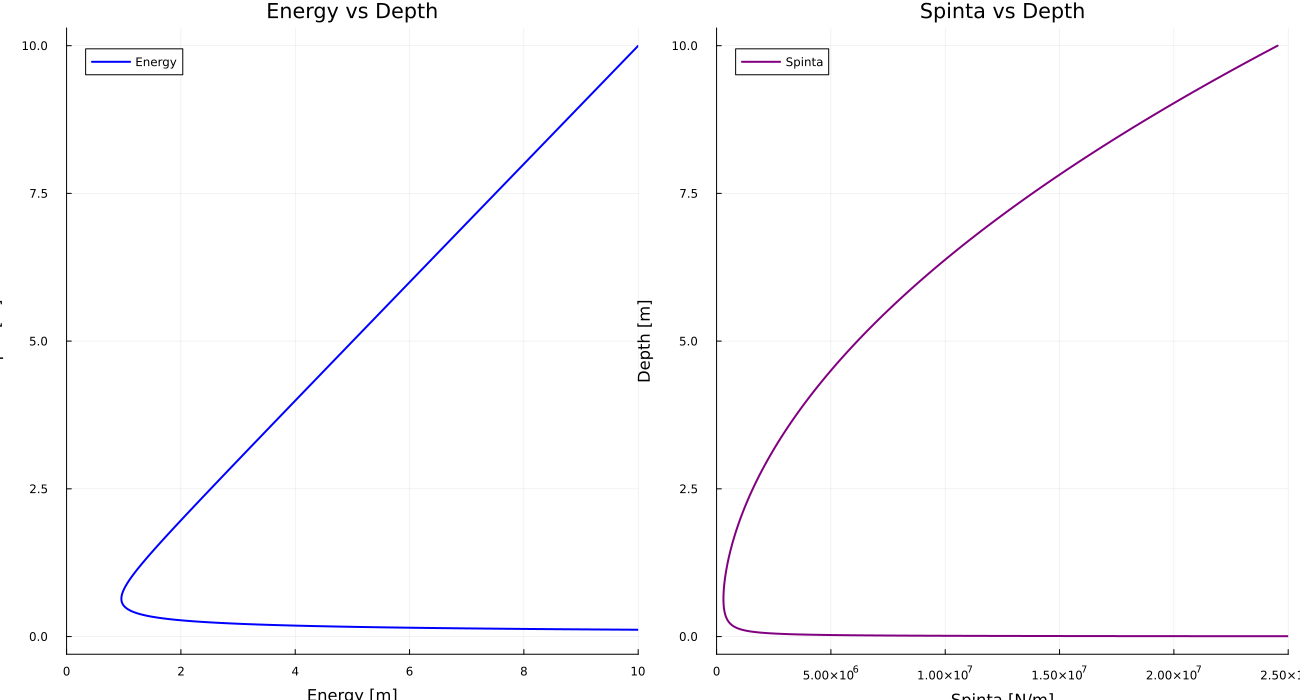

In [43]:
d = 0.0:0.001:10.0            # depth of the channel [m]
Q = 80.0                   # discharge [m^3/s]
B = 50.0                    # width of the channel [m]
ρ = 1000.0                  # water density [kg/m^3]
g = 9.81                    # gravity acceleration [m/s^2]

Spinta(Q, B, d, g, ρ) = 0.5*ρ*g*B*d^2 + ρ*Q^2/(B*d)
Energy(Q, B, d) = d + Q^2/(2*g*(B*d)^2)

S = zeros(length(d))        # water surface elevation [m]
E = zeros(length(d))        # energy elevation [m]
for n in 1:length(d)
    S[n] = Spinta(Q, B, d[n], g, ρ)
    E[n] = Energy(Q, B, d[n])
end

p1 = plot(S, d, label="Spinta", xlabel="Spinta [N/m]", ylabel="Depth [m]",
    title="Spinta vs Depth", grid=true, color="purple", linewidth=2,
    xlim=(0, 2.5e7), size=(600, 550))
p2 = plot(E, d, label="Energy", xlabel="Energy [m]", ylabel="Depth [m]",
    title="Energy vs Depth", grid=true, color="blue", linewidth=2,
    xlim=(0, 10), size=(600, 550))
plot(p2, p1, layout=(1, 2), size=(1300, 700))



The fact that two solutions are at the same time valid make crucial the choice of the side in which to set the BC: subcritical flows are governed by downstream, fast flows are governed by upstream. This means that in principle there are always two valid solution, the first evaluated starting from upstream and the second evaluated from downstream. So, which of the two must be chosen (without enter the computation any time)? The real one is the one that present the greatest Spinta!  

### Implementing procedure
The codes are provided in Julia. The steps for the implementations are the following:
1) Build the geometry and define the $dx$;
2) Solve the Energy ODE (two times) to obtain an Energy profile along the river;
3) Calculate the 2 normal depths for any section;
4) Calculate the Specific Force $S$ for both the depths for each section;
5) Assign the depth with the greatest $S$ between the two (disxrimination between fast/slow flows).
6) Include local discontinuities. 

## Single reach, uniform flow

Number of points along the channel: 1001
first and last x coordinates: 0.0 m, 1000.0 m
first and last z coordinates: 1.0 m, 0.0 m
Uniform depths: 1.3442504755894709 m, Critical depths: 0.7415327354153678 m
Left downward Energy = 1.4570742412056268 m, Right downward Energy = 1.4570753087912023 m
Left upward Energy = 1.4570742412056268 m, Right upward Energy = 1.4570753087912023 m
Spinta for the supercritical depths: 494173.0168461898 N/m, with depth: 0.4499146862204148 m
Spinta for the subcritical depths: 591955.5903478508 N/m, with depth: 1.344259139077015 m


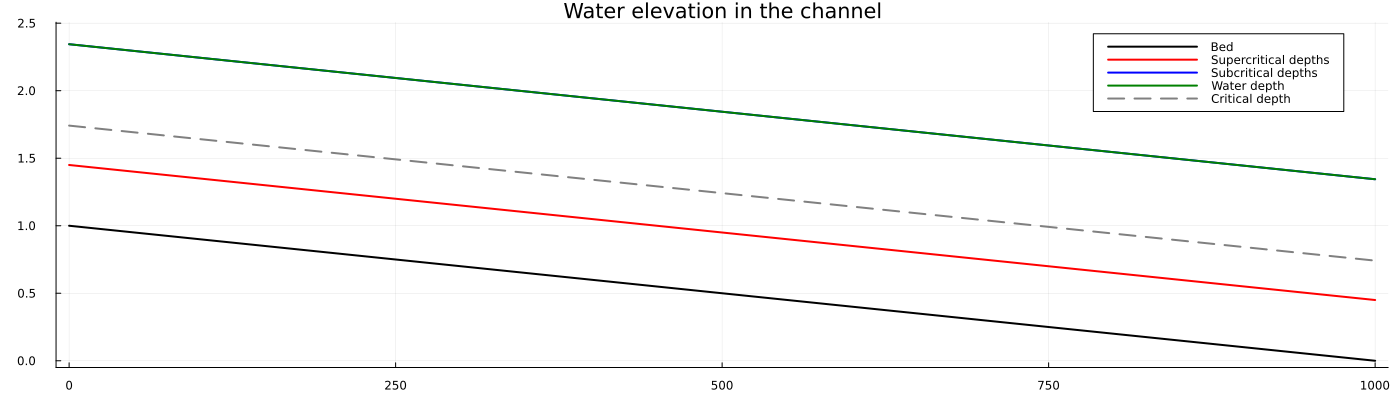

Spinta (generic function with 2 methods)

In [ ]:
# ---------------------- PROBLEM DEFINITION -----------------------

L  = 1000.0       # length of the channel [m]
Q  = 100.0        # discharge [m^3/s] Q = Ω Ks R^2/3 iF^1/2
B  = 50.0         # width of the channel [m]
Ks = 40.0         # Strickler coefficient [m^(1/3)/s] Ks = 1/n
iF = 0.001         # slope of the channel
dx = 1.0          # distance between the points of the channel [m]
g  = 9.81         # gravity acceleration [m/s^2]

# -------------------------- GEOMETRY -----------------------------

# Check the length of the channel is a multiple of dx
L % dx ≠ 0 && error("The length of the channel must be a multiple of dx")
n_points = Int(L/dx) + 1                                    # number of points in the channel
println("Number of points along the channel: ",  n_points)

X = LinRange(0, L, n_points)                                # x coordinates of the points
Z = zeros(n_points)                                         # initialize z coordinates of the points
build_bed!(Z, X, dx, iF, n_points) # build the bed of the channel
println("first and last x coordinates: ", X[begin], " m, ", X[end], " m")
println("first and last z coordinates: ", Z[begin], " m, ", Z[end], " m")

# --------------------- BOUNDARY CONDITIONS ------------------------

# Evaluate the uniform and critical depths
d_uniform, d_critical = evaluate_depths(Q, B, L, Ks, iF)    # evaluate the uniform and critical depths
d_critical_vector = d_critical[1] * ones(length(X))         # vector of critical depths, same length as X
println("Uniform depths: ", d_uniform, " m, Critical depths: ", d_critical, " m")

# The BC are always the uniform flow depth:
eL = d_uniform + Q^2 / (2 * g * (B * d_uniform)^2) # water elevation at the left boundary [begin]
eR = d_uniform + Q^2 / (2 * g * (B * d_uniform)^2) # water elevation at the left boundary [end]

# ------------------------- INTEGRATION -----------------------------

# Solve the energy equation from left to right (downward)
e_dw = zeros(n_points)                          # energy E at the points of the channel
e_dw[1] = eL                                    # initial condition at the left boundary
for n in 2:n_points
    # Evaluate the hydraulic radius:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    # Evaluate the Energy (forward explicit Euler)
    e_dw[n] = e_dw[n-1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left downward Energy = ", e_dw[1], " m, Right downward Energy = ", e_dw[n_points], " m")

# Solve the energy equation from right to left (upward)
e_uw = zeros(n_points)                          # energy E at the points of the channel
e_uw[Npoints] = eR                              # initial condition at the right boundary        
for n in n_points-1:-1:1
    # Evaluate the hydraulic radius:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    # Evaluate the Energy (forward explicit Euler)
    e_uw[n] = e_uw[n+1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left upward Energy = ", e_dw[1], " m, Right upward Energy = ", e_dw[Npoints], " m")

# ------------------------- DEPTHS EVALUATION -----------------------

# From the solution of the energy abstract two depths:
d_fast = zeros(n_points)            # depth from the downward energy
d_slow = zeros(n_points)            # depth from the upward energy   
for n = 1:n_points
    d_fast[n] = E2d(d_critical, Q, B, e_dw[n], style="supercritical")
    d_slow[n] = E2d(d_critical, Q, B, e_uw[n], style="subcritical")
end

# ------------------------- SPINTA EVALUATION -----------------------

# evaluate the Spinta for both the supercritical and subcritical depths
Spinta_fast = zeros(n_points)                   # Spinta for the supercritical depths  
Spinta_slow = zeros(n_points)                   # Spinta for the subcritical depths
for n = 1:n_points
    Spinta_fast[n] = Spinta(Q, B, d_fast[n])    # Spinta for the supercritical depths
    Spinta_slow[n] = Spinta(Q, B, d_slow[n])    # Spinta for the subcritical depths
end
println("Spinta for the supercritical depths: ", Spinta_fast[1], " N/m, with depth: ", d_fast[1], " m")
println("Spinta for the subcritical depths: ", Spinta_slow[1], " N/m, with depth: ", d_slow[1], " m")

# Chose the depth with the maximum Spinta between the two:
d = zeros(n_points)                              # final depth to be plotted
for n = 1:n_points
    # use the supercritical depth if Spinta is greater, otherwise use the subcritical depth
    Spinta_fast[n] > Spinta_slow[n] ? d[n] = d_fast[n] : d[n] = d_slow[n] 
end

# --------------------------- PLOTS -----------------------------

y_limits = (min(minimum(Z), minimum(e_dw)) - 0.05, max(maximum(Z), maximum(Z+e_dw)) + 0.05)
p1 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=y_limits, color="black", linewidth=2,
    size=(1400, 400))
p1 = plot!(X, Z + d_fast, label="Supercritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="red", linewidth=2)
p1 = plot!(X, Z + d_slow, label="Subcritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="blue", linewidth=2)
p1 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
p1 = plot!(X, Z + d_critical_vector, label="Critical depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="gray", linewidth=2, linestyle=:dash)
display(p1)


# -------------------------- FUNCTIONS -----------------------------

@views function evaluate_depths(Q, B, L, Ks, iF)
    # Find the normal depth from the formula above, it is an implicit formula, so adopt an iterative procedure:
    Qnew = 0.0; tol = 1.0e-4; res = 0.1; n = 0; d = 1.0; # initial guess for the depth [m]
    initial_res = Q - B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2);
    while abs(res) >= tol 
        Qnew = B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2)
        res = Q - Qnew;
        increment = res/initial_res*0.1;
        if res > 0 # so the depth is too small
            d += increment; # increase the depth
        else
            d -= increment; # decrease the depth
        end
        n += 1
    end
    c = (Q^2/(9.81*B^2))^(1/3)
    return d, c
end #function

@views function build_bed!(z, x, dx, iF, n_points)
    # build the bed of the channel, the idea is to have always positive z coordinates, and locate
    # the zero of the x coordinate at the most upstream point of the channel
    dz_tot = x[end] * iF            # total z coordinate at the end of the channel, it is a linear function of x
    for n in 1:n_points
        z[n] = -iF * x[n] + dz_tot # z coordinate is a linear function of x, with slope iF
    end
    # return z
end

@views function E2d(d_c, Q, B, e; style)
    g = 9.81 # gravity acceleration [m/s^2]
    if style == "subcritical" 
        d = d_c + 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(obj - e) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d -= increment; # decrease the depth
            else
                d += increment; # increase the depth
            end
        end
    elseif style == "supercritical"
        d = d_c - 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(obj - e) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d += increment; # increase the depth
            else
                d -= increment; # decrease the depth
            end
        end
    else
        error("Style must be either 'subcritical' or 'supercritical'")
    end
    return d
end

Spinta(Q, B, d) = 500*9.81*B*d^2 + 1000*Q^2/(B*d)

As can be seen from the plot above, a case like that leads to the situation in which there is always subcritical flow even if the evaluated normal depth is smaller than the critical one, this comes from the comparison of the Spinta of the two solutions: they both start from the same Energy value, so they both lead to the same situation, the energy value itself is correct, it is not correct the location of the imposition, in fact, looking at the plot:
  
![Why so far it doesn't work properly](images/Spinta_energia.PNG)
  
It is clear that for two depths with the same energy (that is the case) the depth producing subcritical flow present a greater Spinta, always!  
So, the problem is not the energy value (there are no reasons to impose different values) but in the location the imposed BC.

## Multiple reaches

In [ ]:
# ---------------------- PROBLEM DEFINITION -----------------------

n_reaches = 2               # number of reaches in the channel
L  = [1000.0, 1000.0]       # length of the channel [m]
Q  = 100.0                  # discharge [m^3/s] Q = Ω Ks R^2/3 iF^1/2
B  = [50.0, 50.0]           # width of the channel [m]
Ks = [40.0, 40.0]           # Strickler coefficient [m^(1/3)/s] Ks = 1/n
iF = [0.01, 0.001]          # slope of the channel
dx = 1.0                    # distance between the points of the channel [m]
g  = 9.81                   # gravity acceleration [m/s^2]

# -------------------------- GEOMETRY -----------------------------

# Check the lengths of the channel are multiple of dx

n_points = Array{Int64}(undef, n_reaches)                                 # number of points in the channel
B_v, KS, IF = Float64[], Float64[], Float64[]                                   # vector of widths, same length as X
for n_rea in 1:n_reaches
    L[n_rea] % dx ≠ 0 && error("The length of the channel must be a multiple of dx")
    n_points[n_rea] = Int(L[n_rea]/dx) + 1
    println("Number of points along reach ", n_rea, ": ", n_points[n_rea])
    B_v = n_rea == 1 ? B[n_rea] .* ones(n_points[n_rea]) : [B_v, B[n_rea] .* ones(n_points[n_rea])] # vector of widths, same length as X
    KS = n_rea == 1 ? Ks[n_rea] .* ones(n_points[n_rea]) : [KS, Ks[n_rea] .* ones(n_points[n_rea])] # vector of Strickler coefficients
    IF = n_rea == 1 ? iF[n_rea] .* ones(n_points[n_rea]) : [IF, iF[n_rea] .* ones(n_points[n_rea])] # vector of slopes
end

n_points_total = sum(n_points)                              # total number of points in the channel



dX = ones(n_points_total) * dx # DA SISTEMARE, COSI' NON VA



println("Total number of points in the channel: ", n_points_total)

# auxiliary vector
scale = zeros(n_reaches)                                    # scale vector for the z coordinates
for n_rea in n_reaches-1:-1:1
    scale[n_rea] = scale[n_rea+1] + L[n_rea] * iF[n_rea]                    # scale vector for the z coordinates
end
println("Scale vector: ", scale)

X = Float64[]; Z = Float64[]                                # initialize the arrays for the x and z coordinates of the points
for n_rea in 1:n_reaches
    x = LinRange(0, L[n_rea], n_points[n_rea])                     # x coordinates of the points
    z = zeros(n_points[n_rea])                              # initialize z coordinates of the points
    build_bed!(z, x, dx, iF[n_rea], n_points[n_rea])        # build the bed of the channel
    X = n_rea == 1 ? x : vcat(X, x)                             # append the x coordinates as it is
    Z = n_rea == 1 ? z .+ scale[n_rea] : vcat(Z, z .+ scale[n_rea])             # append the z coordinates with the scale
end

println("first and last x coordinates: ", X[1], " m, ", X[end], " m")
println("first and last z coordinates: ", Z[1], " m, ", Z[end], " m")


# --------------------- BOUNDARY CONDITIONS ------------------------

# Evaluate the uniform and critical depths
d_uniform, d_critical = zeros(n_reaches), zeros(n_reaches)    # initialize the vectors for the uniform and critical depths
for n_rea in 1:n_reaches
    d_uniform[n_rea], d_critical[n_rea] = evaluate_depths(Q, B[n_rea], L[n_rea], Ks[n_rea], iF[n_rea])    # evaluate the uniform and critical depths
    # append the critical depth vector
    d_critical_vector = n_rea == 1 ? d_critical[n_rea] .* ones(n_points[n_rea]) : [d_critical_vector, d_critical[n_rea] .* ones(n_points[n_rea])] 
    println("Reach ", n_rea, ": Uniform depth = ", d_uniform[n_rea], " m, Critical depth = ", d_critical[n_rea], " m")
end

# The BC are always the uniform flow depth:
eL = d_uniform[begin] + Q^2 / (2 * g * (B[begin] * d_uniform[begin])^2) # water elevation at the left boundary [begin]
eR = d_uniform[end] + Q^2 / (2 * g * (B[end] * d_uniform[end])^2) # water elevation at the left boundary [end]
println("Left BC E left = ", eL, " m, Right BC E right = ", eR, " m")

# ------------------------- INTEGRATION ----------------------------- HERE THERE IS A PROBLEM
# NB: here we have to solve for E and immediately evaluate the depths from the energy

# Solve the energy equation from left to right (downward)
e_dw = zeros(n_points_total); e_dw[1] = eL                      # energy E at the points of the channel + IC
d_fast = zeros(n_points_total); d_fast[1] = d_uniform[begin]    # depth from the downward energy + IC
for n in 2:n_points_total
    # Evaluate the hydraulic radius:
    Rh = (B_v[n-1] * d_fast[n-1])/(2*d_fast[n-1] + B_v[n-1])
    # Evaluate the Energy (forward explicit Euler)
    e_dw[n] = e_dw[n-1] - dX[n] * (IF[n-1] - (Q/(KS[n-1] * B_v[n-1] * d_fast[n-1]))^2 * Rh^(-4/3))
    d_fast[n] = E2d(d_critical_vector[n], Q, B_v[n], e_dw[n], style="supercritical")
end
println("Left downward Energy = ", e_dw[1], " m, Right downward Energy = ", e_dw[n_points_total], " m")

# Solve the energy equation from right to left (upward)
e_uw = zeros(n_points_total); e_uw[end] = eR                    # energy E at the points of the channel + IC
d_slow = zeros(n_points_total); d_slow[end] = d_uniform[end]    # depth from the upward energy + IC
for n in n_points-1:-1:1
    # Evaluate the hydraulic radius:
    Rh = (B_v[n+1] * d_slow[n+1])/(2*d_slow[n+] + B_v[n+1])
    # Evaluate the Energy (forward explicit Euler)
    e_uw[n] = e_uw[n+1] - dx * (IF[n+1] - (Q/(KS[n+1] * B_v[n+1] * d_slow[n+1]))^2 * Rh^(-4/3))
    d_slow[n] = E2d(d_critical_vector[n], Q, B_v[n], e_dw[n], style="supercritical")
end
println("Left upward Energy = ", e_dw[1], " m, Right upward Energy = ", e_dw[Npoints], " m")

#=
# ------------------------- SPINTA EVALUATION -----------------------

# evaluate the Spinta for both the supercritical and subcritical depths
Spinta_fast = zeros(n_points_total)                   # Spinta for the supercritical depths  
Spinta_slow = zeros(n_points_total)                   # Spinta for the subcritical depths
for n = 1:n_points_total
    Spinta_fast[n] = Spinta(Q, B_v[n], d_fast[n])    # Spinta for the supercritical depths
    Spinta_slow[n] = Spinta(Q, B_v[n], d_slow[n])    # Spinta for the subcritical depths
end
#println("Spinta for the supercritical depths: ", Spinta_fast[1], " N/m, with depth: ", d_fast[1], " m")
#println("Spinta for the subcritical depths: ", Spinta_slow[1], " N/m, with depth: ", d_slow[1], " m")

# Chose the depth with the maximum Spinta between the two:
d = zeros(n_points_total)                              # final depth to be plotted
for n = 1:n_points_total
    # use the supercritical depth if Spinta is greater, otherwise use the subcritical depth
    Spinta_fast[n] > Spinta_slow[n] ? d[n] = d_fast[n] : d[n] = d_slow[n] 
end

# --------------------------- PLOTS -----------------------------

y_limits = (min(minimum(Z), minimum(e_dw)) - 0.05, max(maximum(Z), maximum(Z+e_dw)) + 0.05)
p1 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=y_limits, color="black", linewidth=2,
    size=(1400, 400))
p1 = plot!(X, Z + d_fast, label="Supercritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="red", linewidth=2)
p1 = plot!(X, Z + d_slow, label="Subcritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="blue", linewidth=2)
p1 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
p1 = plot!(X, Z + d_critical_vector, label="Critical depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="gray", linewidth=2, linestyle=:dash)
display(p1)
=#

Number of points along reach 1: 1001
Number of points along reach 2: 1001
Total number of points in the channel: 2002
Scale vector: [10.0, 0.0]
first and last x coordinates: 0.0 m, 1000.0 m
first and last z coordinates: 20.0 m, 0.0 m
Reach 1: Uniform depth = 0.6667367963050687 m, Critical depth = 0.7415327354153678 m
Reach 2: Uniform depth = 1.3442504755894709 m, Critical depth = 0.7415327354153678 m
Left BC E left = 1.125355899184775 m, Right BC E right = 1.4570742412056268 m


MethodError: MethodError: no method matching +(::Float64, ::Vector{Float64})
For element-wise addition, use broadcasting with dot syntax: scalar .+ array
The function `+` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:596
  +(::Real, !Matched::Complex{Bool})
   @ Base complex.jl:322
  +(!Matched::Array, ::Array...)
   @ Base arraymath.jl:12
  ...


# -------------------------- GEOMETRY -----------------------------

L = [1000.0]        # length of the channel [m]
Q = 100.0            # discharge [m^3/s] Q = Ω Ks R^2/3 iF^1/2
B = [50.0]         # width of the channel [m]
Ks = 40.0           # Strickler coefficient [m^(1/3)/s] Ks = 1/n
iF = [0.05]        # slope of the channel
dx = 1.0           # distance between the points of the channel [m]
g = 9.81            # gravity acceleration [m/s^2]

n_segments = 1 # number of segments of the channel (with different slopes)
d_uniform  = Array{Float64}(undef, n_segments) # array to store the uniform depths
d_critical = Array{Float64}(undef, n_segments) # array to store the critical depths
X = Float64[] # x coordinates of the points in the channel
Z = Float64[] # z coordinates of the points in the channel
for n in 1:n_segments
    d_uniform[n], d_critical[n] = evaluate_depths(Q, B[n], L[n], Ks, iF[n])
    L[n]%dx ≠ 0 && error("The length of the channel must be a multiple of dx")
    n_points = Int(L[n]/dx) + 1         # number of points in the channel
    println("Number of points in channel ", n, " is ",  n_points)
    x = LinRange(0, L[n], n_points)                     # x coordinates of the points
    z = zeros(n_points)                 # z coordinates of the points, initially all zero
    build_bed!(z, x, dx, iF[n], n_points) # build the bed of the channel
    X = n == 1 ? x : [X, x]
    Z = n == 1 ? z : [Z, z] # concatenate the arrays for the first segment or the others
end
d_critical_vector = d_critical[1] * ones(length(X)) # vector of critical depths, same length as X

# The water elevation has no need to be initialized, just the two extreems values for the BC
# The BC are always the uniform flow depth:
α = 1.0 # correction factor for the non prismaticity of the channel
eL = d_uniform[1] + Q^2 / (2 * g * (B[1] * d_uniform[1])^2) # water elevation at the left boundary [begin]
eR = d_uniform[1] + Q^2 / (2 * g * (B[1] * d_uniform[1])^2) # water elevation at the left boundary [end]


println("Uniform depths: ", d_uniform, " m, Critical depths: ", d_critical, " m")
println("first and last x coordinates: ", X[begin], " m, ", X[end], " m")
println("first and last z coordinates: ", Z[begin], " m, ", Z[end], " m")

 
Npoints = length(X)
e_dw = zeros(Npoints) # energy E at the points of the channel
e_dw[1] = eL

# Solve the energy equation from left to right (downward)
for n in 2:Npoints
    # integration of the solution:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    e_dw[n] = e_dw[n-1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left downward Energy = ", e_dw[1], " m, Right downward Energy = ", e_dw[Npoints], " m")

# Solve the energy equation from right to left (upward)
e_uw = zeros(Npoints) # energy E at the points of the channel
e_uw[Npoints] = eR
for n in Npoints-1:-1:1
    # integration of the solution:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    e_uw[n] = e_uw[n+1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left upward Energy = ", e_dw[1], " m, Right upward Energy = ", e_dw[Npoints], " m")

# From the solution of the energy abstract two depths:
d_fast = zeros(Npoints) # depth from the downward energy
d_slow = zeros(Npoints) # depth from the upward energy   
for n = 1:Npoints
    # The depth is the energy minus the kinetic energy:
    d_fast[n] = E2d(d_critical[1], Q, B[1], e_dw[n], style="supercritical")
    d_slow[n] = E2d(d_critical[1], Q, B[1], e_uw[n], style="subcritical")
end

# evaluate the Spinta for both the supercritical and subcritical depths
Spinta_fast = zeros(Npoints) # Spinta for the supercritical depths  
Spinta_slow = zeros(Npoints) # Spinta for the subcritical depths
for n = 1:Npoints
    Spinta_fast[n] = Spinta(Q, B[1], d_fast[n]) # Spinta for the supercritical depths
    Spinta_slow[n] = Spinta(Q, B[1], d_slow[n]) # Spinta for the subcritical depths
end
println("Spinta for the supercritical depths: ", Spinta_fast[1], " N/m, with depth: ", d_fast[1], " m")
println("Spinta for the subcritical depths: ", Spinta_slow[1], " N/m, with depth: ", d_slow[1], " m")


# Chose the depth with the maximum Spinta between the two:
d = zeros(Npoints) # final depth to be plotted
for n = 1:Npoints
    if Spinta_fast[n] > Spinta_slow[n]
        d[n] = d_fast[n] # use the supercritical depth
    else
        d[n] = d_slow[n] # use the subcritical depth
    end
end

y_limits = (min(minimum(Z), minimum(e_dw)) - 0.05, max(maximum(Z), maximum(Z+e_dw)) + 0.05)
p1 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=y_limits, color="black", linewidth=2,
    size=(1400, 400))
p1 = plot!(X, Z + d_fast, label="Supercritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="red", linewidth=2)
p1 = plot!(X, Z + d_slow, label="Subcritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="blue", linewidth=2)
p1 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
p1 = plot!(X, Z + d_critical_vector, label="Critical depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="gray", linewidth=2, linestyle=:dash)
display(p1)


# -------------------------- FUNCTIONS -----------------------------

@views function evaluate_depths(Q, B, L, Ks, iF)
    # Find the normal depth from the formula above, it is an implicit formula, so adopt an iterative procedure:
    Qnew = 0.0; tol = 1.0e-4; res = 0.1; n = 0; d = 1.0; # initial guess for the depth [m]
    initial_res = Q - B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2);
    while abs(res) >= tol 
        Qnew = B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2)
        res = Q - Qnew;
        increment = res/initial_res*0.1;
        if res > 0 # so the depth is too small
            d += increment; # increase the depth
        else
            d -= increment; # decrease the depth
        end
        n += 1
    end
    c = (Q^2/(9.81*B^2))^(1/3)
    return d, c
end #function

@views function build_bed!(z, x, dx, iF, n_points)
    # build the bed of the channel, the idea is to have always positive z coordinates, and locate
    # the zero of the x coordinate at the most upstream point of the channel
    dz_tot = x[end] * iF            # total z coordinate at the end of the channel, it is a linear function of x
    for n in 1:n_points
        z[n] = -iF * x[n] + dz_tot # z coordinate is a linear function of x, with slope iF
    end
    # return z
end

@views function E2d(d_c, Q, B, e; style)
    g = 9.81 # gravity acceleration [m/s^2]
    if style == "subcritical" 
        d = d_c + 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(obj - e) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d -= increment; # decrease the depth
            else
                d += increment; # increase the depth
            end
        end
    elseif style == "supercritical"
        d = d_c - 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(obj - e) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d += increment; # increase the depth
            else
                d -= increment; # decrease the depth
            end
        end
    else
        error("Style must be either 'subcritical' or 'supercritical'")
    end
    return d
end

Spinta(Q, B, d) = 500*9.81*B*d^2 + 1000*Q^2/(B*d)